In [8]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

import random
import torch

from tqdm import tqdm
from useful_functions import fidelity, random_state
from data import generates_data

In [9]:
# In this part we define the architecture for our model. We require two channel inputs for convolutional layers and, in the latent space, we introduce a scalar parameter.
# The output is a two channel image that represents the output state, real and imaginary part.

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=2)  # Output: 8 x 3 x 3
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2)  # Output: 16 x 2 x 2
        
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 2 * 2 + 1, 32)  # Flattened vector + scalar parameter
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 4 * 4 * 2)  # Output for the 4x4x2 image
        
    def forward(self, x, scalar_param):
        # Convolutional layers with Tanh activation
        x = torch.tanh(self.conv1(x))  # Output: 8 x 3 x 3
        x = torch.tanh(self.conv2(x))  # Output: 16 x 2 x 2
        
        # Flatten the output of the convolutional layer
        x = x.flatten()  # Flatten: 16*2*2 = 64
        x = torch.cat((x, scalar_param))  # Concatenate: 64 + 1 = 65
        
        # Fully connected layers with Tanh activation
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        
        # Output layer
        x = torch.tanh(self.fc3(x))
        
        # Reshape to obtain the output with size 4x4x2
        x = x.view(2, 4, 4)
        
        return x
    
model = Net()

In [10]:
# For us, the model is already trained so we just have to upload the weights of the network with the saved values

trained_model = torch.load('model.pth', map_location=torch.device('cpu'))
model.load_state_dict(trained_model)

<All keys matched successfully>

In [11]:
# As we did in CNN_train.ipynb, we have to define the specific Hamiltonian used in the training step

sigma_x = np.array([[0, 1], 
                    [1, 0]], dtype=complex)

sigma_y = np.array([[0, -1j], 
                    [1j, 0]], dtype=complex)

sigma_z = np.array([[1, 0], 
                    [0, -1]], dtype=complex)

pauli_basis = [np.eye(2, dtype=complex), sigma_x, sigma_y, sigma_z]

H = np.kron(pauli_basis[1], pauli_basis[1]) + np.kron(pauli_basis[3], pauli_basis[3])

In [12]:
# To compute the fidelity we must adapt the outcomes of the Neural Network to construct the density matrix for, then, compute the
# fidelity using the respective function defined in useful_functions.py

def fid(prediction, target):
    # Computes the fidelity between the predicted and target density matrices.
    
    # Parameters:
    # prediction (torch.Tensor): Tensor containing the real and imaginary parts of the predicted density matrix.
    # target (torch.Tensor): Tensor containing the real and imaginary parts of the target density matrix.
    
    # Returns:
    # float: Fidelity value between the target and prediction.

    # Reconstruct the predicted density matrix from its real and imaginary components
    rho_prediction = prediction[0] + 1j * prediction[1]
    
    # Perform SVD to ensure rho_prediction is positive semi-definite and normalized
    U, S, Vh = torch.linalg.svd(rho_prediction)
    
    # Rebuild the density matrix using the SVD result, ensuring it is Hermitian and positive semi-definite
    rho_prediction = U @ torch.diag(torch.complex(S, torch.zeros_like(S))) @ torch.conj(U).T
    rho_prediction = rho_prediction / torch.trace(rho_prediction)  # Normalize to ensure trace 1
    
    # Convert the tensor to a numpy array for fidelity calculation
    rho_prediction = rho_prediction.detach().numpy()

    # Reconstruct the target density matrix from its real and imaginary components
    rho_target = target[0] + 1j * target[1]
    rho_target = rho_target.detach().numpy()
    rho_target = rho_target / np.trace(rho_target)  # Normalize the target density matrix

    # Calculate fidelity using the function you defined earlier
    return fidelity(rho_target, rho_prediction, lib="numpy")

In [13]:
# We generates the random data and, then, for each input we compute the respective output using our model and the theoretical evolution.
# After that, the fidelity tell us the difference between those states. Values close to 1 means that the states are closely identical
# and values close to 0 means that the states are completely different

N_data  = 10000
fids    = []

inputs, outputs = generates_data(N_data = N_data, n_qubits = 2, Hamiltonian = H)

for n_data in tqdm(range(N_data)):
    prediction  = model(inputs[0][n_data], inputs[1][n_data])
    target      = outputs[n_data]

    fids.append(fid(prediction, target))

100%|██████████| 10000/10000 [00:01<00:00, 5050.40it/s]


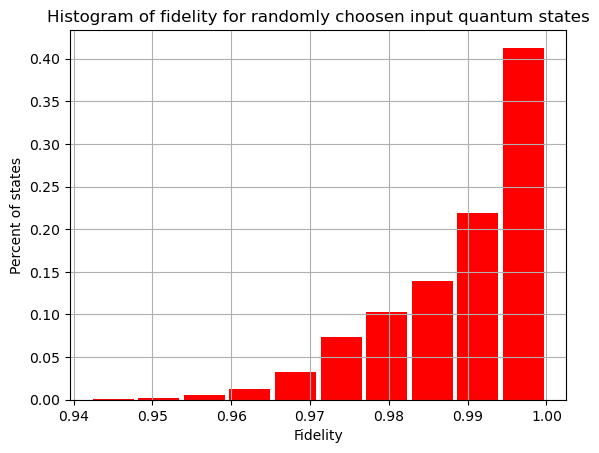

In [14]:
# We plot the results with a histogram that show how good is our model to describe the evolution of the states.

counts, bins = np.histogram(fids)
counts  = counts/np.sum(counts)

plt.hist(bins[:-1], bins, weights=counts, color="red", rwidth=0.9)
plt.grid()
plt.xlabel("Fidelity")
plt.ylabel("Percent of states")
plt.title("Histogram of fidelity for randomly choosen input quantum states")

plt.show()